In [30]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import scipy.stats as sps
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(1488)

import warnings
warnings.filterwarnings("ignore")

# Общее описание задания

В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.

Данные будут предоставлены в формате csv. Они будут содержать также часть пред экспериментального этапа.

**Описание эксперимента:**  
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле.

**Метрика:**  
средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

**Важная информация:**  
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

**Описание данных:**  
id_product -  идентификатор продукта, который был рекомендован  
is_pay - купил ли пользователь товар  
sum_payment - размер платежа (0, если не купил)  
city - город, в котором находится пользователь  
id_user - пользователь  
timestamp - timestamp события  
date - дата события  

**Задачи, которые необходимо решить:**  
1. Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.  
2. Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.  
3. Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.  

**Дополнительно:**  
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

# Загрузка и предобработка данных

In [6]:
df = pd.read_csv("ab_made_4.gzip", compression='gzip')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') + timedelta(hours=3)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df["group"] = df["group"].fillna("pre")

df["id_user"] = df["id_user"].apply(lambda x: x[5:])
df["id_user"] = df["id_user"].astype(int)

In [7]:
df.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,2023-04-01 09:29:33,9903,27,pre,Санкт-Петербург,4.0,1,2023-04-01
1,2023-04-01 10:04:12,6732,0,pre,Рязань,1.0,0,2023-04-01
2,2023-04-01 22:40:39,4199,0,pre,Москва,3.0,0,2023-04-01
3,2023-04-01 11:26:20,3606,12,pre,Санкт-Петербург,7.0,1,2023-04-01
4,2023-04-01 10:33:09,9519,0,pre,Санкт-Петербург,14.0,0,2023-04-01


# Задача 1: Длительность теста

**Посмотреть, есть ли выбросы в данных.**

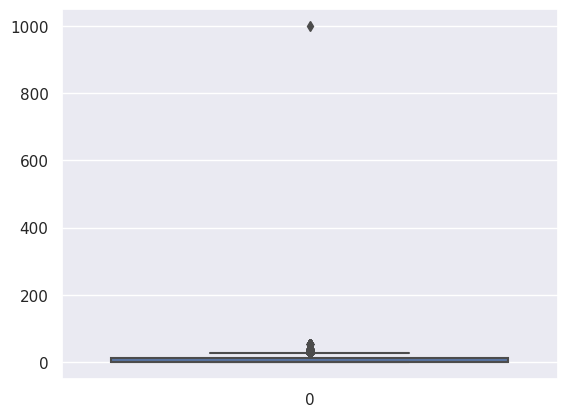

In [36]:
sns.boxplot(df[df.group == "pre"].sum_payment);

In [50]:
threshold = 0.01
lower_bound = df[df.group == "pre"].sum_payment.quantile(q=threshold)
upper_bound = df[df.group == "pre"].sum_payment.quantile(q=1-threshold)
lower_bound, upper_bound

(0.0, 37.0)

In [58]:
df.loc[df[(df.group == "pre") & (df.sum_payment < lower_bound)].index, "sum_payment"] = lower_bound
df.loc[df[(df.group == "pre") & (df.sum_payment > upper_bound)].index, "sum_payment"] = upper_bound

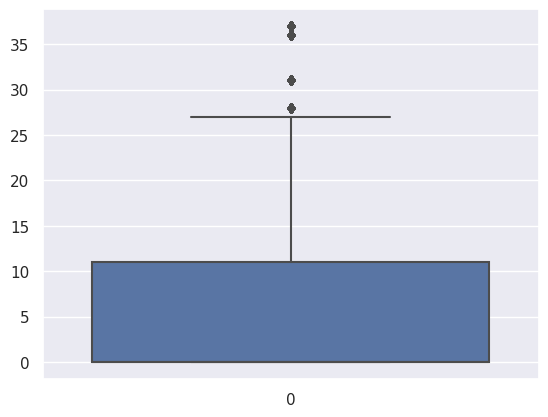

In [69]:
sns.boxplot(df[df.group == "pre"].sum_payment);

In [70]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [71]:
def compute_metric(df, ending, exp=False):
    filter_df = df.groupby('id_user').timestamp.min().reset_index(name='min_timestamp')
    filter_df['max_timestamp'] = filter_df['min_timestamp'] + timedelta(seconds=7 * 24 * 60 * 60)
    df2 = df.merge(filter_df, on='id_user')
    df2 = df2[(df2['timestamp'] <= df2['max_timestamp']) & (df2['timestamp'] >= df2['min_timestamp'])]
    df2 = df2[pd.to_datetime(df2['max_timestamp']).dt.normalize() <= ending]
    return df2.groupby('id_user').sum_payment.sum().tolist()

**Оценить длительность теста на момент его начала. Для оценки необходимо использовать данные с пред экспериментального периода.**

In [72]:
metric_vals = compute_metric(df[df.group == "pre"], df[df.group == "pre"].timestamp.max())
sigma_1 = np.std(metric_vals)
sigma_2 = sigma_1
effect = 0.1 * np.mean(metric_vals)
k = df[df.group == "A"].id_user.nunique() / df[df.group == "B"].id_user.nunique()

test_duration = int(duration(1, effect, sigma_1, sigma_2, alpha=0.05, beta=0.2)/2)
print(f"Размер выборки {test_duration} пользователей")

Размер выборки 3570 пользователей


In [73]:
def df_filter(df, exp_start, exp_end, duration):
    date = exp_start + timedelta(days=7)
    while True:
        if date == exp_end:
            return date
        tmp_df = df[df['date'] <= date]
        filtered_df = tmp_df.groupby('id_user').timestamp.min().reset_index(name='min_timestamp')
        filtered_df['max_timestamp'] = filtered_df['min_timestamp'] + timedelta(seconds=7 * 24 * 60 * 60)
        filtered_df = filtered_df[pd.to_datetime(filtered_df['max_timestamp']).dt.normalize() <= date]
        if filtered_df.id_user.nunique() >= duration:
            return date
        date = date + timedelta(days=1)

In [74]:
exp_start = pd.to_datetime('2023-05-01', format='%Y-%m-%d')
exp_end = pd.to_datetime('2023-05-31', format='%Y-%m-%d')

a_group_date = df_filter(df[df.group == "A"], exp_start, exp_end, test_duration)
b_group_date = df_filter(df[df.group == "B"], exp_start, exp_end, test_duration)
exp_end = max(a_group_date, b_group_date)

In [77]:
print(f"Дата окончания: {exp_end.date()}")

Дата окончания: 2023-05-31


# Задача 2: Целевая метрика

**Посмотреть, есть ли выбросы в данных.**

In [78]:
a_group_df = df[(df.group == "A") & (df.date <= exp_end)]
b_group_df = df[(df.group == "B") & (df.date <= exp_end)]

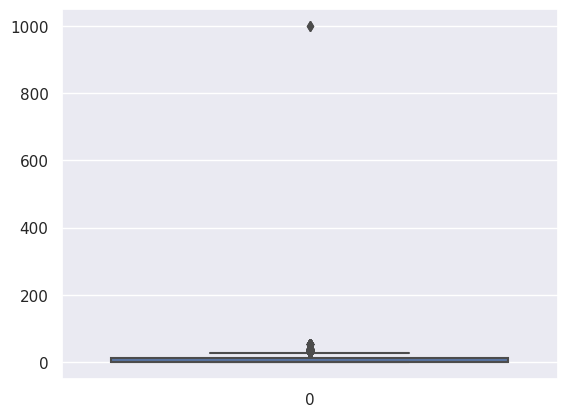

In [93]:
sns.boxplot(a_group_df.sum_payment.values);

In [95]:
lower_bound = a_group_df.sum_payment.quantile(q=threshold)
upper_bound = a_group_df.sum_payment.quantile(q=1-threshold)
lower_bound, upper_bound

(0.0, 37.0)

In [96]:
a_group_df.loc[a_group_df[(a_group_df.sum_payment < lower_bound)].index, "sum_payment"] = lower_bound
a_group_df.loc[a_group_df[(a_group_df.sum_payment > upper_bound)].index, "sum_payment"] = upper_bound

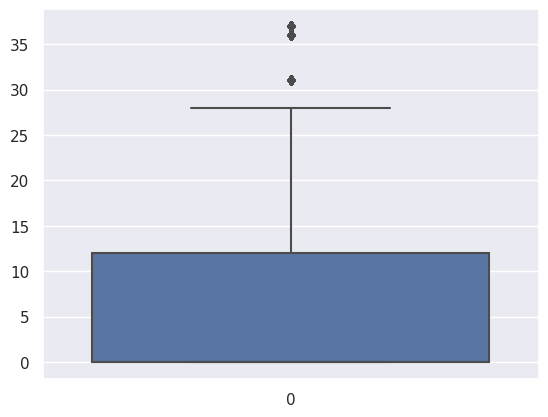

In [97]:
sns.boxplot(a_group_df.sum_payment.values);

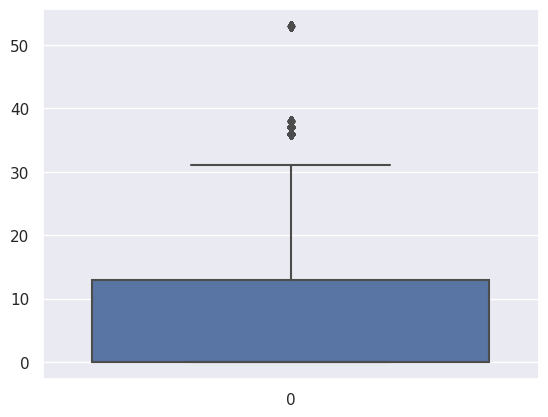

In [98]:
sns.boxplot(b_group_df.sum_payment.values);

In [99]:
lower_bound = b_group_df.sum_payment.quantile(q=threshold)
upper_bound = b_group_df.sum_payment.quantile(q=1-threshold)
lower_bound, upper_bound

(0.0, 37.0)

In [100]:
b_group_df.loc[b_group_df[(b_group_df.sum_payment < lower_bound)].index, "sum_payment"] = lower_bound
b_group_df.loc[b_group_df[(b_group_df.sum_payment > upper_bound)].index, "sum_payment"] = upper_bound

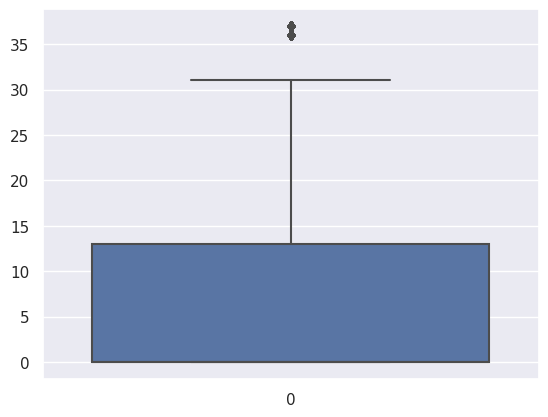

In [101]:
sns.boxplot(b_group_df.sum_payment.values);

**Рассчитать целевую метрику на день окончания.**

In [102]:
def compute_dynamic_metric(a_df, b_df, exp_start, exp_end):
    result_df = pd.DataFrame(
        [],
        columns=["metric_a", "metric_b", "effect", "t", "p_value"],
        index=pd.date_range(exp_start + timedelta(days=7), exp_end),
    )
    for date in result_df.index:
        tmp_a = compute_metric(a_df[a_df["date"] <= date], ending=date, exp=True)
        tmp_b = compute_metric(b_df[b_df["date"] <= date], ending=date, exp=True)
        effect = np.mean(tmp_b) - np.mean(tmp_a)
        results = sps.ttest_ind(tmp_a, tmp_b, equal_var=abs(np.var(tmp_b) - np.var(tmp_a)) <= 0.1)
        t, p_value = results.statistic, results.pvalue
        result_df.loc[date] = np.mean(tmp_a), np.mean(tmp_b), effect, t, p_value
    return result_df

In [104]:
result_df = compute_dynamic_metric(a_group_df, b_group_df, exp_start, exp_end)
result_df.tail(1)

,metric_a,metric_b,effect,t,p_value
2023-05-31,11.281241,12.69074,1.409499,-3.368989,0.000759


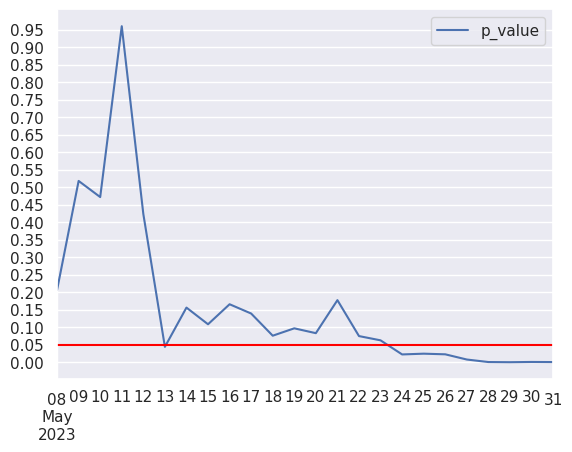

In [106]:
result_df.plot(y='p_value', grid=True, yticks=np.arange(0, 1, 0.05))
plt.plot(result_df.index, [0.05] * len(result_df.index), color='red')
plt.show()

**Как видно по таблице, группа B выигрывает**,  
`p-value: 0.000759 < 0.05`